Do necessary imports.

In [85]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

Settings of the experiment:

In [90]:
MONOCHROME=False
IMG_SIZE=50
EPOCHS=10

def get_color_param():
    if MONOCHROME:
        return cv2.COLOR_BGR2GRAY
    else:
        return cv2.COLOR_BGR2RGB

def get_num_color_channel():
    if MONOCHROME:
        return 1
    else:
        return 3

def get_display_img_cmap():
    if MONOCHROME:
        return "gray"
    else:
        return None

Import raw images from the `./data/` directory which contains folders
for `wolves` and `dogs`. Labels: `dogs=1`, `wolves=0`.

In [91]:
images = []
labels = [] # dogs = 1 # wolfs = 0

for root, dirs, files in os.walk('data'):
    for name in files:
            file_name = os.path.join(root, name)
            labels.append(int('dogs' in file_name))
            image = cv2.imread(file_name, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, get_color_param())
            images.append(image)

Save imported data blobs to file for later use.

In [92]:
with open('dog_wolf_files.sav', 'wb') as outfile:
    pickle.dump((labels, images), outfile)

Import image and label data from file.

In [93]:
with open('dog_wolf_files.sav', 'rb') as infile:
    labels, images = pickle.load(infile)

Create `ImageScaler` class that scales the images to the desired width and height and also
normalizing the pixel values from `[0, 255]` to `[0.0, 1.0]`

In [94]:
class ImageScaler:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def scale(self, images):
        if type(images) is list:
            image_list = [self.scale(image) for image in images]
            return image_list
        else:
            resized_image = cv2.resize(images, (self.height, self.width))
            return resized_image / 255.0


scaler = ImageScaler(width=IMG_SIZE, height=IMG_SIZE)
scaled_images = scaler.scale(images)

Split the scaled images and labels in train and testing data after shuffling the input array
to ensure a random split among classes.

In [95]:
train_images, test_images, train_labels, test_labels = train_test_split(scaled_images, labels, shuffle=True)

Reshape train and test images to match the input shape of the network.

In [96]:
train_images = tf.reshape(train_images, [-1, IMG_SIZE, IMG_SIZE, get_num_color_channel()])
test_images = tf.reshape(test_images, [-1, IMG_SIZE, IMG_SIZE, get_num_color_channel()])

Define neural network structure and compile it.

In [97]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, get_num_color_channel()), padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, get_num_color_channel())),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 32)          18464     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 32)         

Train the created model using the train images for `20` epochs.
After training the model is evaluated using the test images and labels.

In [98]:
model.fit(train_images,  np.array(train_labels), epochs=EPOCHS)
test_loss, test_acc = model.evaluate(test_images,  np.array(test_labels), verbose=2)

Epoch 1/10
47/47 [==============================] - 6s 127ms/step - loss: 0.6938 - accuracy: 0.4940

Load images of Odin and scale them to fit the requirements for inputting into the neural network.

In [99]:
odin_images = []

for root, dirs, files in os.walk('odin-pictures'):
    for name in files:
            file_name = os.path.join(root, name)
            image = cv2.imread(file_name, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, get_color_param())
            odin_images.append(image)

odin_images = scaler.scale(odin_images)
odin_images = tf.reshape(odin_images, [-1, IMG_SIZE, IMG_SIZE, get_num_color_channel()])

Feed rescaled test images into the neural network for classification to obtain an array
of predictions.

In [100]:
predictions = model.predict(odin_images)

Display prediction results of Odin images.

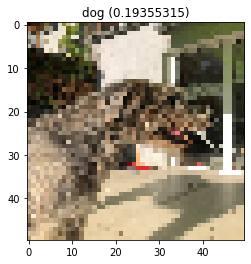

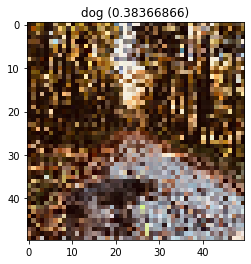

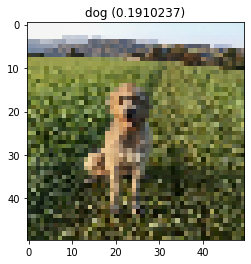

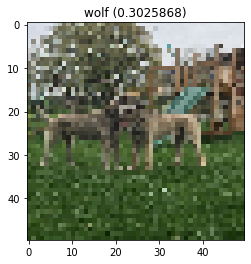

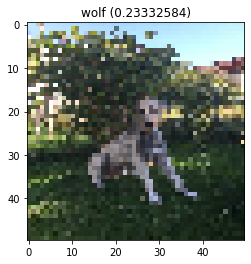

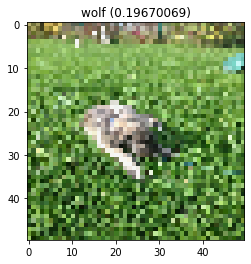

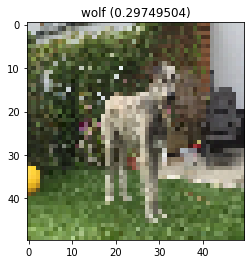

In [101]:
for i, image in enumerate(odin_images):
    plt.imshow(image,cmap=get_display_img_cmap())
    if predictions[i][0] > predictions[i][1]:
        title = "wolf (" + str(predictions[i][0]) + ")"
    else:
        title = "dog (" + str(predictions[i][1]) + ")"
    plt.title(title)
    plt.show()